Notebook Color Schemes:


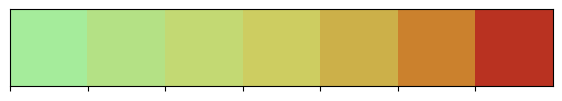

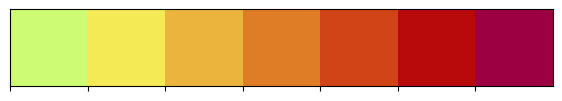

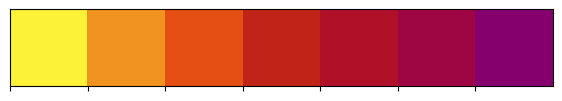

In [1]:
# Libraries
import os
import gc
from time import time
import random
import math
import glob
import json
from bisect import bisect
from scipy.sparse import vstack
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Spacy Language Detector
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'AI4Code', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[93m'
    E = '\033[0m'
    
my_colors = ["#CDFC74", "#F3EA56", "#EBB43D", 
             "#DF7D27", "#D14417", "#B80A0A", "#9C0042"]
my_pastels = ["#A5EC9B", "#B4E185", "#C3D973", 
             "#CDCD61", "#CCB049", "#CB812D", "#B93221"]
my_darks = ["#FCF238", "#F19321", "#E54F14", 
             "#C22318", "#B01028", "#9D0642", "#85006C"]

gradient1 = ["#a5ec9b", "#abe890", "#b0e485", "#b7e07b", "#bddb71", 
             "#c3d667", "#cad15e", "#d1cc55", "#d7c64e", "#dec147", "#e5ba41", "#ebb43d"]
CMAP1 = ListedColormap(my_colors)
CMAP2 = ListedColormap(my_colors[-1])

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_pastels))
sns.palplot(sns.color_palette(my_colors))
sns.palplot(sns.color_palette(my_darks))
plt.show()

In [7]:
def count_inversions(a):
    '''src: https://www.kaggle.com/code/ryanholbrook/getting-started-with-ai4code'''
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    '''src: https://www.kaggle.com/code/ryanholbrook/getting-started-with-ai4code'''
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max


def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [8]:
!pip install spacy

In [2]:
# Read in original data
import pandas as pd
orders = pd.read_csv("train_orders.csv")
ancestors = pd.read_csv("train_ancestors.csv")

In [3]:
print(clr.S+"~~~~ TRAIN ~~~~"+clr.E)
print(clr.S+"Orders:"+clr.E)
print(f"Shape: {orders.shape} with {orders.id.nunique()} unique IDs.", "\n")
orders.head()

~~~~ TRAIN ~~~~
Orders:
Shape: (139256, 2) with 139256 unique IDs. 



,id,cell_order
0,00001756c60be8,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...
1,00015c83e2717b,2e94bd7a 3e99dee9 b5e286ea da4f7550 c417225b 5...
2,0001bdd4021779,3fdc37be 073782ca 8ea7263c 80543cd8 38310c80 0...
3,0001daf4c2c76d,97266564 a898e555 86605076 76cc2642 ef279279 d...
4,0002115f48f982,9ec225f0 18281c6c e3b6b115 4a044c54 365fe576 a...


In [4]:
print(clr.S+"Ancestors:"+clr.E)
print(f"Shape: {ancestors.shape} also with {ancestors.id.nunique()} unique IDs.")
print(f"There are also {ancestors.ancestor_id.nunique()} unique ancestor_id and {ancestors.parent_id.nunique()} unique parent_id.")
ancestors.head()

Ancestors:
Shape: (139256, 3) also with 139256 unique IDs.
There are also 125372 unique ancestor_id and 13630 unique parent_id.


,id,ancestor_id,parent_id
0,00001756c60be8,945aea18,NaN
1,00015c83e2717b,aa2da37e,317b65d12af9df
2,0001bdd4021779,a7711fde,NaN
3,0001daf4c2c76d,090152ca,NaN
4,0002115f48f982,272b483a,NaN


In [5]:
# Get frequency per ancestor_id
data = ancestors.groupby("ancestor_id")["id"].count().reset_index().\
                sort_values("id", ascending=False).reset_index(drop=True)
data.columns = ["ancestor_id", "count"]


# Basic metrics
total_singles = data[data["count"]==1].shape[0]
total_double_plus = data[data["count"]>1].shape[0]

print(clr.S+"Total number of ids with only 1 ancestor:"+clr.E, total_singles, "\n"+ "\t"*4+
      clr.S+"percent:"+clr.E, round(total_singles/len(data), 3), "\n")
print(clr.S+"Total number of ids with 2+ ancestors:"+clr.E, total_double_plus, "\n"+ "\t"*4+
      clr.S+"percent:"+clr.E, round(total_double_plus/len(data), 3))

Total number of ids with only 1 ancestor: 118529 
				percent: 0.945 

Total number of ids with 2+ ancestors: 6843 
				percent: 0.055


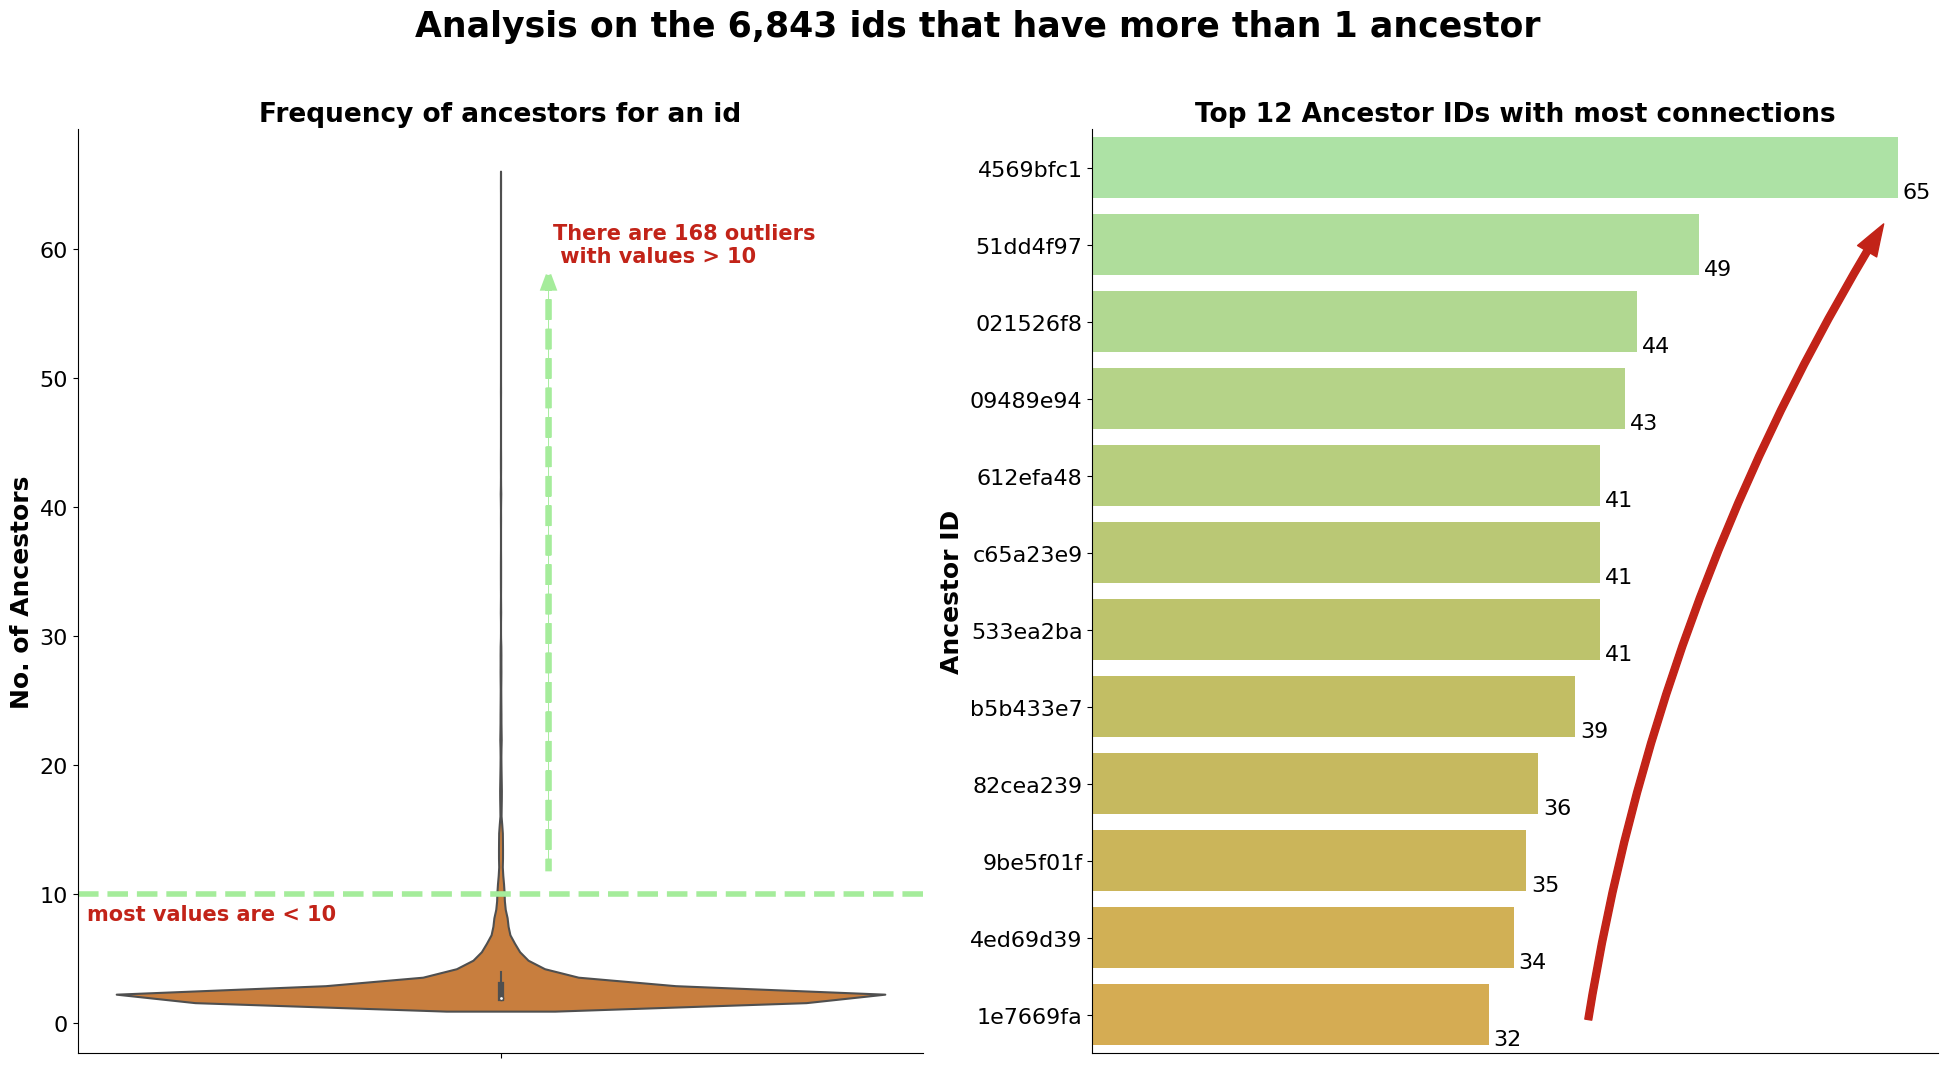

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Analysis on the 6,843 ids that have more than 1 ancestor', 
             weight="bold", size=25)

# Violinplot
sns.violinplot(data=data[data["count"]>1], y="count", ax=ax1, color=my_colors[3])
ax1.set_title("Frequency of ancestors for an id", weight="bold", size=19)
ax1.set_ylabel("No. of Ancestors", size = 18, weight="bold")
ax1.axhline(y=10, linestyle = '--', color=my_pastels[0], lw=4)
ax1.text(x=-0.43, y=8, s="most values are < 10", color=my_darks[3], size=15, weight="bold")
ax1.arrow(x=0.05, y=12, dx=0, dy=45, color=my_pastels[0], lw=4, 
          head_width=0.01, head_length=1, linestyle = '--')
ax1.text(x=0.055, y=59, s="There are 168 outliers \n with values > 10",
         color=my_darks[3], size=15, weight="bold")

# Barplot
sns.barplot(data=data[data["count"]>1].head(12), x="count", y="ancestor_id", ax=ax2, 
            palette=gradient1)
show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_title("Top 12 Ancestor IDs with most connections", weight="bold", size=19)
ax2.set_ylabel("Ancestor ID", size = 18, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

# Arrow
style = "Simple, tail_width=5, head_width=16, head_length=23"
kw = dict(arrowstyle=style, color=my_darks[3])
arrow = patches.FancyArrowPatch((40, 11.1), (64, 0.7),
                             connectionstyle="arc3,rad=-.10", **kw)
plt.gca().add_patch(arrow)

sns.despine(right=True, top=True);

In [12]:
def get_json_data(ID):
    '''
    Returns a df containing the .json information.
    ID: name of file
    return :: a df comtaining cols "cell_id", "cell_type", "source"
    '''

    # Read in the .json file
    file = json.load(open(f"./train/{ID}.json"))

    # Create an empty dataframe of size n
    # where n = numver of cell ids in the notebook
    n = len(file["cell_type"].keys())
    df = pd.DataFrame(index=range(n),columns=["cell_id", "cell_type", "source"])

    # Get all sources in order
    all_sources = list(file["source"].values())

    # Add cell id and type to dataframe
    for k, (cell_id, cell_type) in enumerate(file["cell_type"].items()):
        df.loc[k, "cell_id"] = cell_id
        df.loc[k, "cell_type"] = cell_type
        # as cell_id is in the same order for both "cell_type" and "source"
        df.loc[k, "source"] = all_sources[k]
        
    return df

In [13]:
# Show an example
ID = "00001756c60be8"

example_df = get_json_data(ID)
example_df.head()

,cell_id,cell_type,source
0,1862f0a6,code,# This Python 3 environment comes with many he...
1,2a9e43d6,code,import numpy as np\nimport pandas as pd\nimpor...
2,038b763d,code,import warnings\nwarnings.filterwarnings('igno...
3,2eefe0ef,code,matplotlib.rcParams.update({'font.size': 14})
4,0beab1cd,code,"def evaluate_preds(train_true_values, train_pr..."


In [15]:
# Language Detector Function
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)

# Load spacy model
nlp_model = spacy.load("en_core_web_sm")

# Create instance for language detection
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

In [16]:
def get_document_language(ID):
    '''
    Returns the language of the document.
    ID: name of file
    return :: dictionary containing the language and score (probability)
    '''
    # Retrieve .json df
    df = get_json_data(ID)

    # Get a string of all doc text
    # Keep only first 200 chars to not overload memory
    all_doc_text = " ".join(df[df["cell_type"]=="markdown"]["source"].tolist())[:200]

    # Get document language
    doc = nlp_model(all_doc_text)
    language = doc._.language
    
    return language

In [17]:
# An example
ID = "00001756c60be8"
language = get_document_language(ID)

print(clr.S+f"--- Notebook: {ID} ---"+clr.E)
print(clr.S+"The language of this document is:"+clr.E, language["language"])
print(clr.S+"With a probability of:"+clr.E, language["score"])

--- Notebook: 00001756c60be8 ---
The language of this document is: ru
With a probability of: 0.9999956677096207


In [ ]:
# === Uncomment this cell to run it ===

# Retrieve all languages for all notebooks
all_languages = []

# This takes ~ 1hr 15 mins
for k, ID in tqdm(enumerate(orders["id"])):
    all_languages.append(get_document_language(ID))
    
# Convert to dataframe
all_lang_df = pd.DataFrame(all_languages)
all_lang_df["id"] = orders["id"]

# Save file
# .parquet is smaller than .csv
all_lang_df.to_parquet("all_languages.parquet", index=False)

In [20]:
all_lang_df.to_parquet("all_languages.parquet", index=False)

In [21]:
all_lang_df.head()

,language,score,id
0,ru,0.999996,00001756c60be8
1,en,0.999998,00015c83e2717b
2,en,0.999999,0001bdd4021779
3,en,0.999996,0001daf4c2c76d
4,en,0.999996,0002115f48f982


In [22]:
# Import external mapping of the languages
iso_codes = pd.read_csv("ISO_languages_codes.csv")

# Add full name
all_lang_df = all_lang_df.merge(right=iso_codes, 
                                left_on="language", right_on="2_letter_code", 
                                how="left").iloc[:, :4]

all_lang_df.head()

,language,score,id,iso_language_name
0,ru,0.999996,00001756c60be8,Russian
1,en,0.999998,00015c83e2717b,English
2,en,0.999999,0001bdd4021779,English
3,en,0.999996,0001daf4c2c76d,English
4,en,0.999996,0002115f48f982,English


In [23]:
all_lang_df.to_parquet("all_languages_mapped.parquet", index=False)

In [24]:
all_lang_df["is_en"] = all_lang_df["language"].apply(lambda x: "English" if x =="en" else "Other")

# # 🐝 Log into W&B
# wandb.log({"distinct_languages" : all_lang_df["iso_language_name"].nunique(),
#            "perc_en_notebooks" : all_lang_df["iso_language_name"].value_counts()[0]/len(all_lang_df["iso_language_name"])})

print(clr.S+"Total number of unique languages present within the notebooks:"+clr.E,
      all_lang_df["iso_language_name"].nunique())
print(clr.S+"Percentage of notebooks in English:"+clr.E,
      all_lang_df["iso_language_name"].value_counts()[0]/len(all_lang_df["iso_language_name"]), "\n")
print(clr.S+"Other languages:"+clr.E,
      all_lang_df["iso_language_name"].value_counts().index[1:].tolist())

Total number of unique languages present within the notebooks: 44
Percentage of notebooks in English: 0.902747457919228 

Other languages: ['Portuguese', 'Russian', 'Turkish', 'Japanese', 'Italian', 'Korean', 'Spanish, Castilian', 'German', 'French', 'Indonesian', 'Catalan, Valencian', 'Vietnamese', 'Tagalog', 'Romanian,\xa0Moldavian, Moldovan', 'Norwegian', 'Danish', 'Estonian', 'Afrikaans', 'Dutch,\xa0Flemish', 'Somali', 'Polish', 'Swedish', 'Welsh', 'Thai', 'Finnish', 'Ukrainian', 'Bulgarian', 'Persian', 'Croatian', 'Hungarian', 'Swahili', 'Slovenian', 'Lithuanian', 'Czech', 'Arabic', 'Albanian', 'Greek, Modern (1453–)', 'Latvian', 'Slovak', 'Macedonian', 'Hebrew', 'Bengali', 'Hindi']


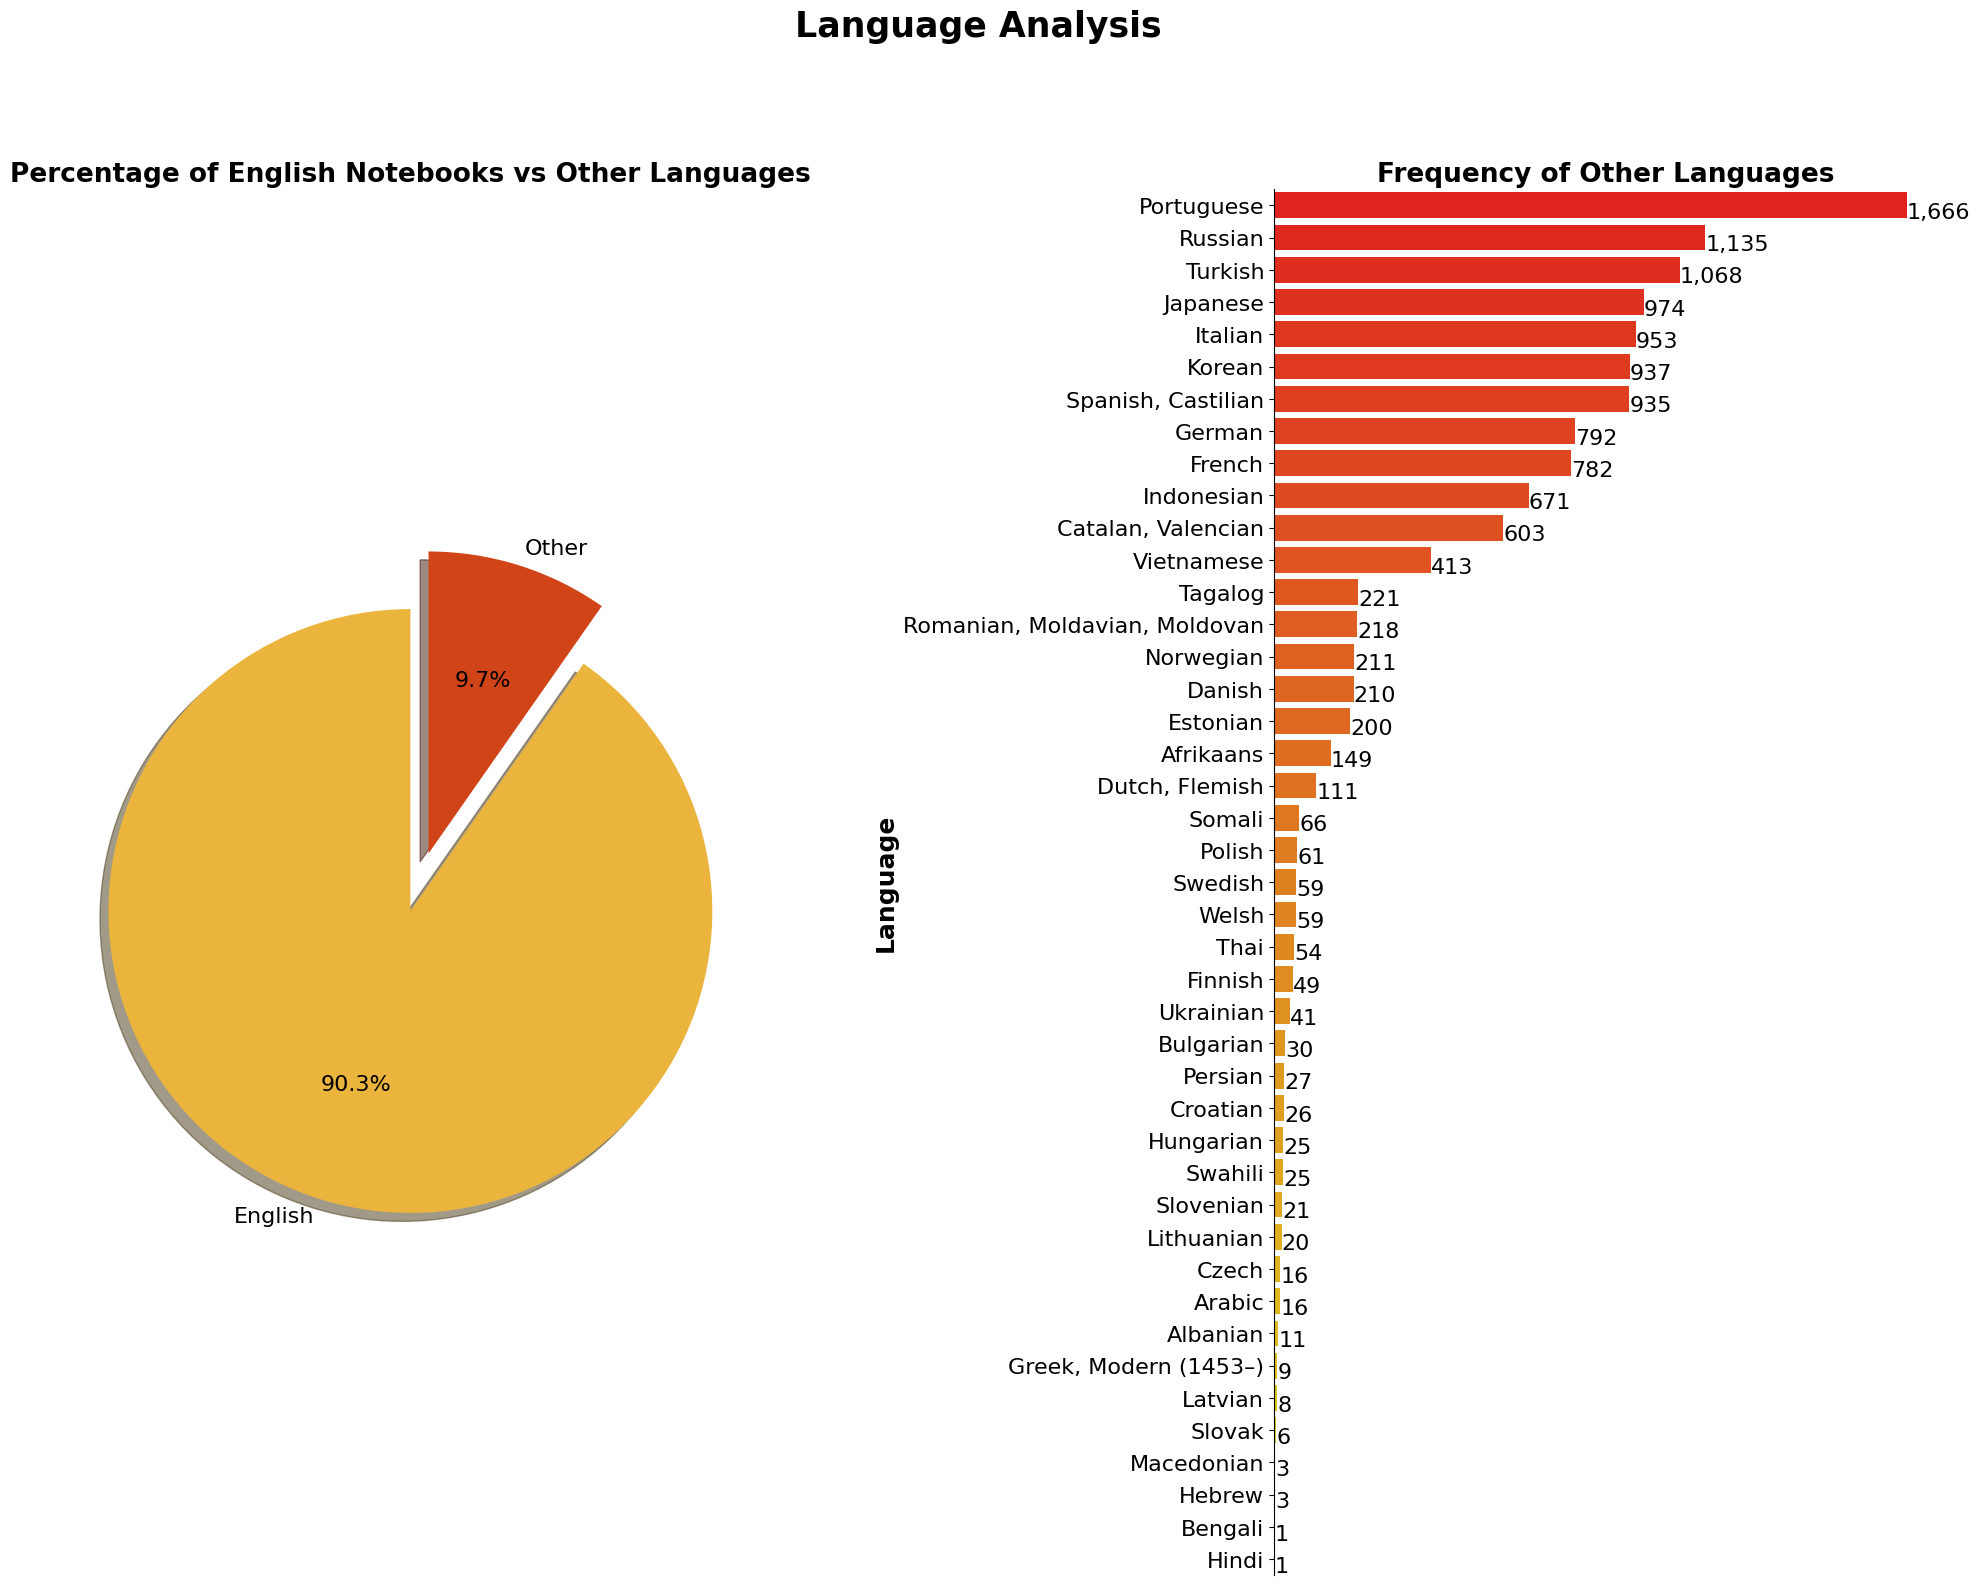

In [25]:
# Barchart data
data = all_lang_df["iso_language_name"].value_counts().reset_index()
data.columns = ["language", "count"]
data = data[data["language"]!="English"]

# Piechart data
labels = all_lang_df["is_en"].value_counts().index.tolist()
sizes = all_lang_df["is_en"].value_counts().values.tolist()
explode = (0, 0.2)

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 18))
fig.suptitle('Language Analysis',weight="bold", size=25)

# Pie
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=[my_colors[2], my_colors[4]],
        labeldistance=1.06)
ax1.set_title("Percentage of English Notebooks vs Other Languages", weight="bold", size=19)
ax1.axis('equal')

sns.barplot(data=data, x="count", y="language", ax=ax2, 
            palette="autumn")
show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_title("Frequency of Other Languages", weight="bold", size=19)
ax2.set_ylabel("Language", size = 18, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
sns.despine(right=True, top=True, bottom=True);

In [28]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRanker
from scipy import sparse

In [29]:
# ~~~ For now I will REMOVE all notebooks that are not in english ~~~

# Filter out other languages
only_english = all_lang_df[all_lang_df["iso_language_name"]=="English"].reset_index(drop=True)

# Merge
data = pd.merge(left=orders, right=only_english, on="id").iloc[:, :2]

del iso_codes, all_lang_df
gc.collect()

921

In [30]:
data["cell_order"] = data["cell_order"].apply(lambda x: x.split())
data = data.explode("cell_order").reset_index(drop=True)

# Create rank
data['rank'] = 1
data['rank'] = data.groupby(['id'])['rank'].cumsum()

data.head()

,id,cell_order,rank
0,00015c83e2717b,2e94bd7a,1
1,00015c83e2717b,3e99dee9,2
2,00015c83e2717b,b5e286ea,3
3,00015c83e2717b,da4f7550,4
4,00015c83e2717b,c417225b,5


=== Metrics ===
Min no. of cells: 2 
Mean no. of cells: 46.02236841058602 
Max no. of cells: 1005


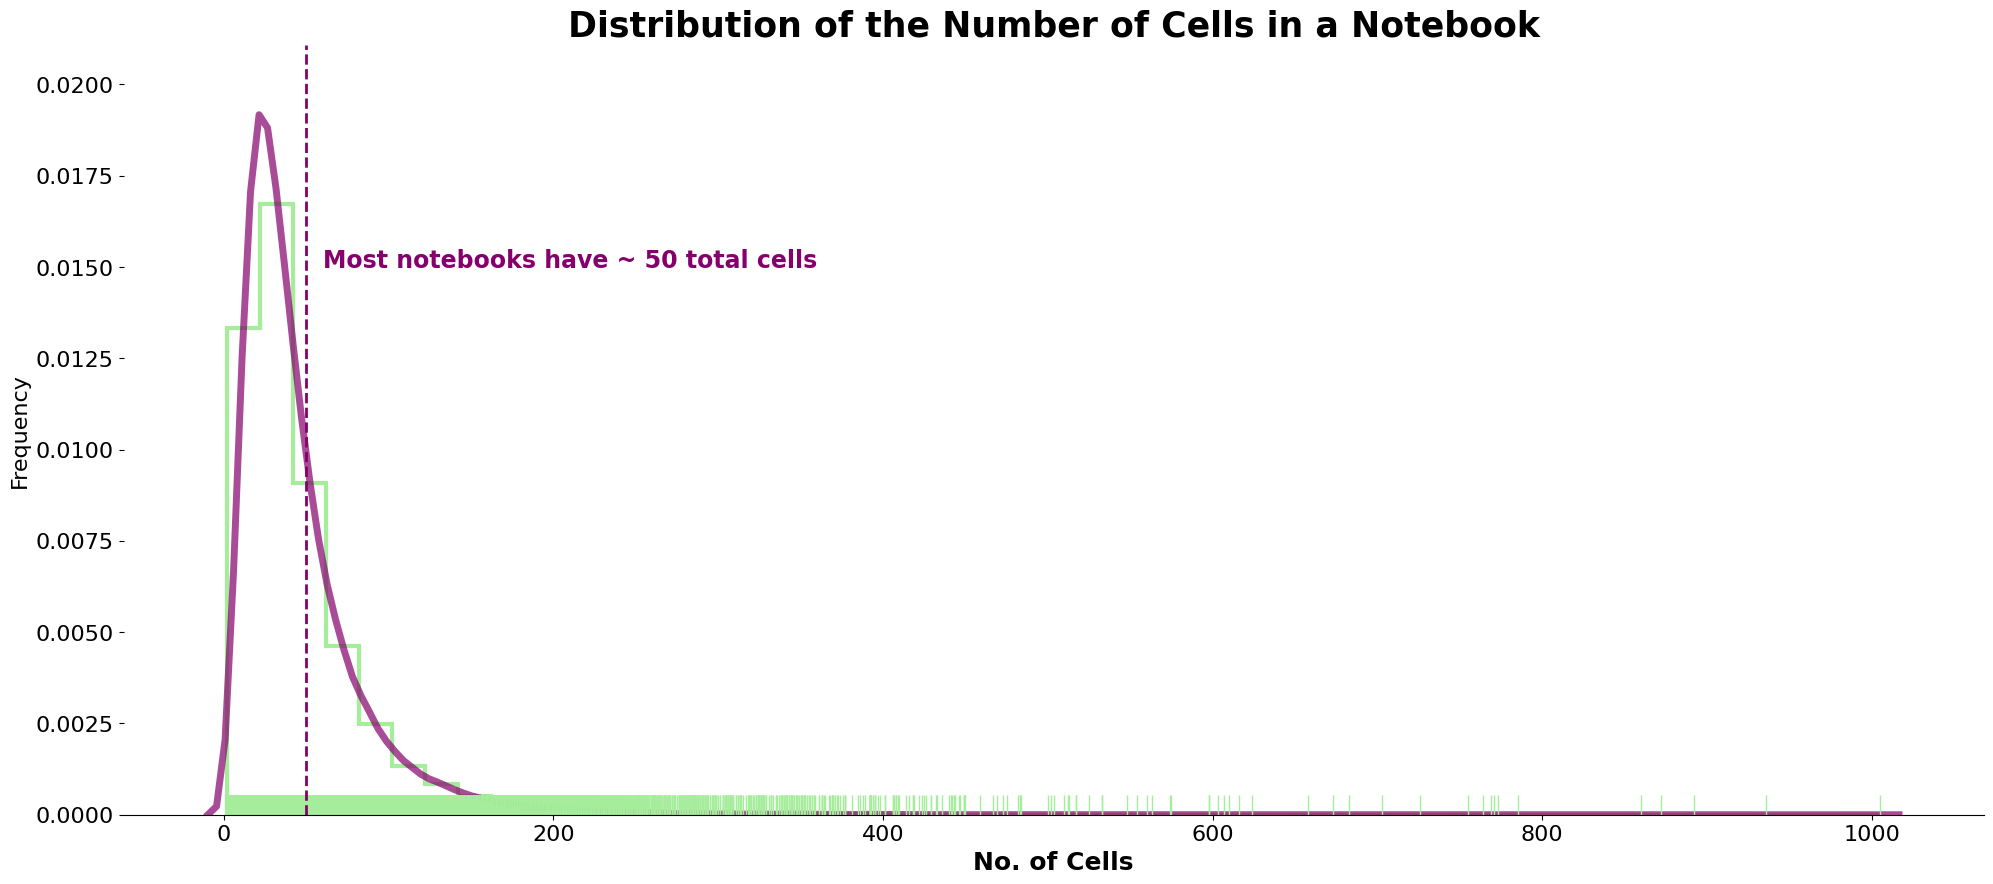

In [31]:
no_cells = data.groupby("id")["rank"].max().values

# Plot
print(clr.S+"=== Metrics ==="+clr.E)
print(clr.S+"Min no. of cells:"+clr.E, no_cells.min(), "\n" +
      clr.S+"Mean no. of cells:"+clr.E, no_cells.mean(), "\n" +
      clr.S+"Max no. of cells:"+clr.E, no_cells.max())

plt.figure(figsize=(24, 10))
sns.distplot(no_cells, rug=True,
             rug_kws={"color": my_pastels[0]},
             kde_kws={"color": my_darks[-1], "lw": 5, "alpha": 0.7},
             hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_pastels[0]})

plt.title("Distribution of the Number of Cells in a Notebook", weight="bold", size=25)
plt.xlabel("No. of Cells", size = 18, weight="bold")
plt.ylabel("Frequency")

plt.axvline(x=50, linestyle = '--', color=my_darks[-1], lw=2)
plt.text(x=60, y=0.015, s=f"Most notebooks have ~ 50 total cells", 
         color=my_darks[-1], size=17, weight="bold")

sns.despine(right=True, top=True, left=True);

In [32]:
del no_cells
gc.collect()

111

In [33]:
# === Uncomment this cell to run it ===

# Get all data from the .json files
all_id_data = []

for ID in tqdm(data["id"].unique()):
    id_data = get_json_data(ID)
    id_data["id"] = [ID] * len(id_data)
    all_id_data.append(id_data)
    
# Concatenate all dataframes together
train = pd.DataFrame(columns=["cell_id", "cell_type", "source", "id"])
train = pd.concat(all_id_data)

# Merge Rank info
train = pd.merge(left=train, right=data, 
                 left_on=["id", "cell_id"], right_on=["id", "cell_order"])
train.drop(columns="cell_order", inplace=True)

# Compute the percentage rank
# Divide each rank to the total number of cells within a notebook
train["percent_rank"] = train["rank"] / train.groupby("id")["cell_id"].transform("count")

# Add ancestor data
train = pd.merge(left=train, right=ancestors, on=["id"])

train.to_parquet("train.parquet", index=False)

100%|█████████████████████████████████████████████████████████████████████████| 125713/125713 [15:25<00:00, 135.82it/s]


In [50]:
train.head()

,cell_id,cell_type,source,id,rank,percent_rank,ancestor_id,parent_id
0,c417225b,code,import numpy as np # linear algebra\nimport pa...,00015c83e2717b,5,0.053763,aa2da37e,317b65d12af9df
1,51e3cd89,code,"input_dir = ""../input/""",00015c83e2717b,6,0.064516,aa2da37e,317b65d12af9df
2,2600b4eb,code,"train_df = pd.read_csv(""../input/train.csv"")\n...",00015c83e2717b,7,0.075269,aa2da37e,317b65d12af9df
3,75b65993,code,class_dict = defaultdict(int)\n\nkind_class_di...,00015c83e2717b,8,0.086022,aa2da37e,317b65d12af9df
4,cf195f8b,code,"print(""the number of images with no defects: {...",00015c83e2717b,9,0.096774,aa2da37e,317b65d12af9df


In [52]:
train[train.id == '00015c83e2717b']

,cell_id,cell_type,source,id,rank,percent_rank,ancestor_id,parent_id
0,c417225b,code,import numpy as np # linear algebra\nimport pa...,00015c83e2717b,5,0.053763,aa2da37e,317b65d12af9df
1,51e3cd89,code,"input_dir = ""../input/""",00015c83e2717b,6,0.064516,aa2da37e,317b65d12af9df
2,2600b4eb,code,"train_df = pd.read_csv(""../input/train.csv"")\n...",00015c83e2717b,7,0.075269,aa2da37e,317b65d12af9df
3,75b65993,code,class_dict = defaultdict(int)\n\nkind_class_di...,00015c83e2717b,8,0.086022,aa2da37e,317b65d12af9df
4,cf195f8b,code,"print(""the number of images with no defects: {...",00015c83e2717b,9,0.096774,aa2da37e,317b65d12af9df
...,...,...,...,...,...,...,...,...
88,ceba8ae0,markdown,"* All image have same shape, (1600, 256).",00015c83e2717b,20,0.215054,aa2da37e,317b65d12af9df
89,f2915b9f,markdown,#### Start with binary classification here,00015c83e2717b,53,0.569892,aa2da37e,317b65d12af9df
90,3e99dee9,markdown,## About The Competition : Detecting Steel Def...,00015c83e2717b,2,0.021505,aa2da37e,317b65d12af9df
91,da4f7550,markdown,## import modules and define models,00015c83e2717b,4,0.043011,aa2da37e,317b65d12af9df


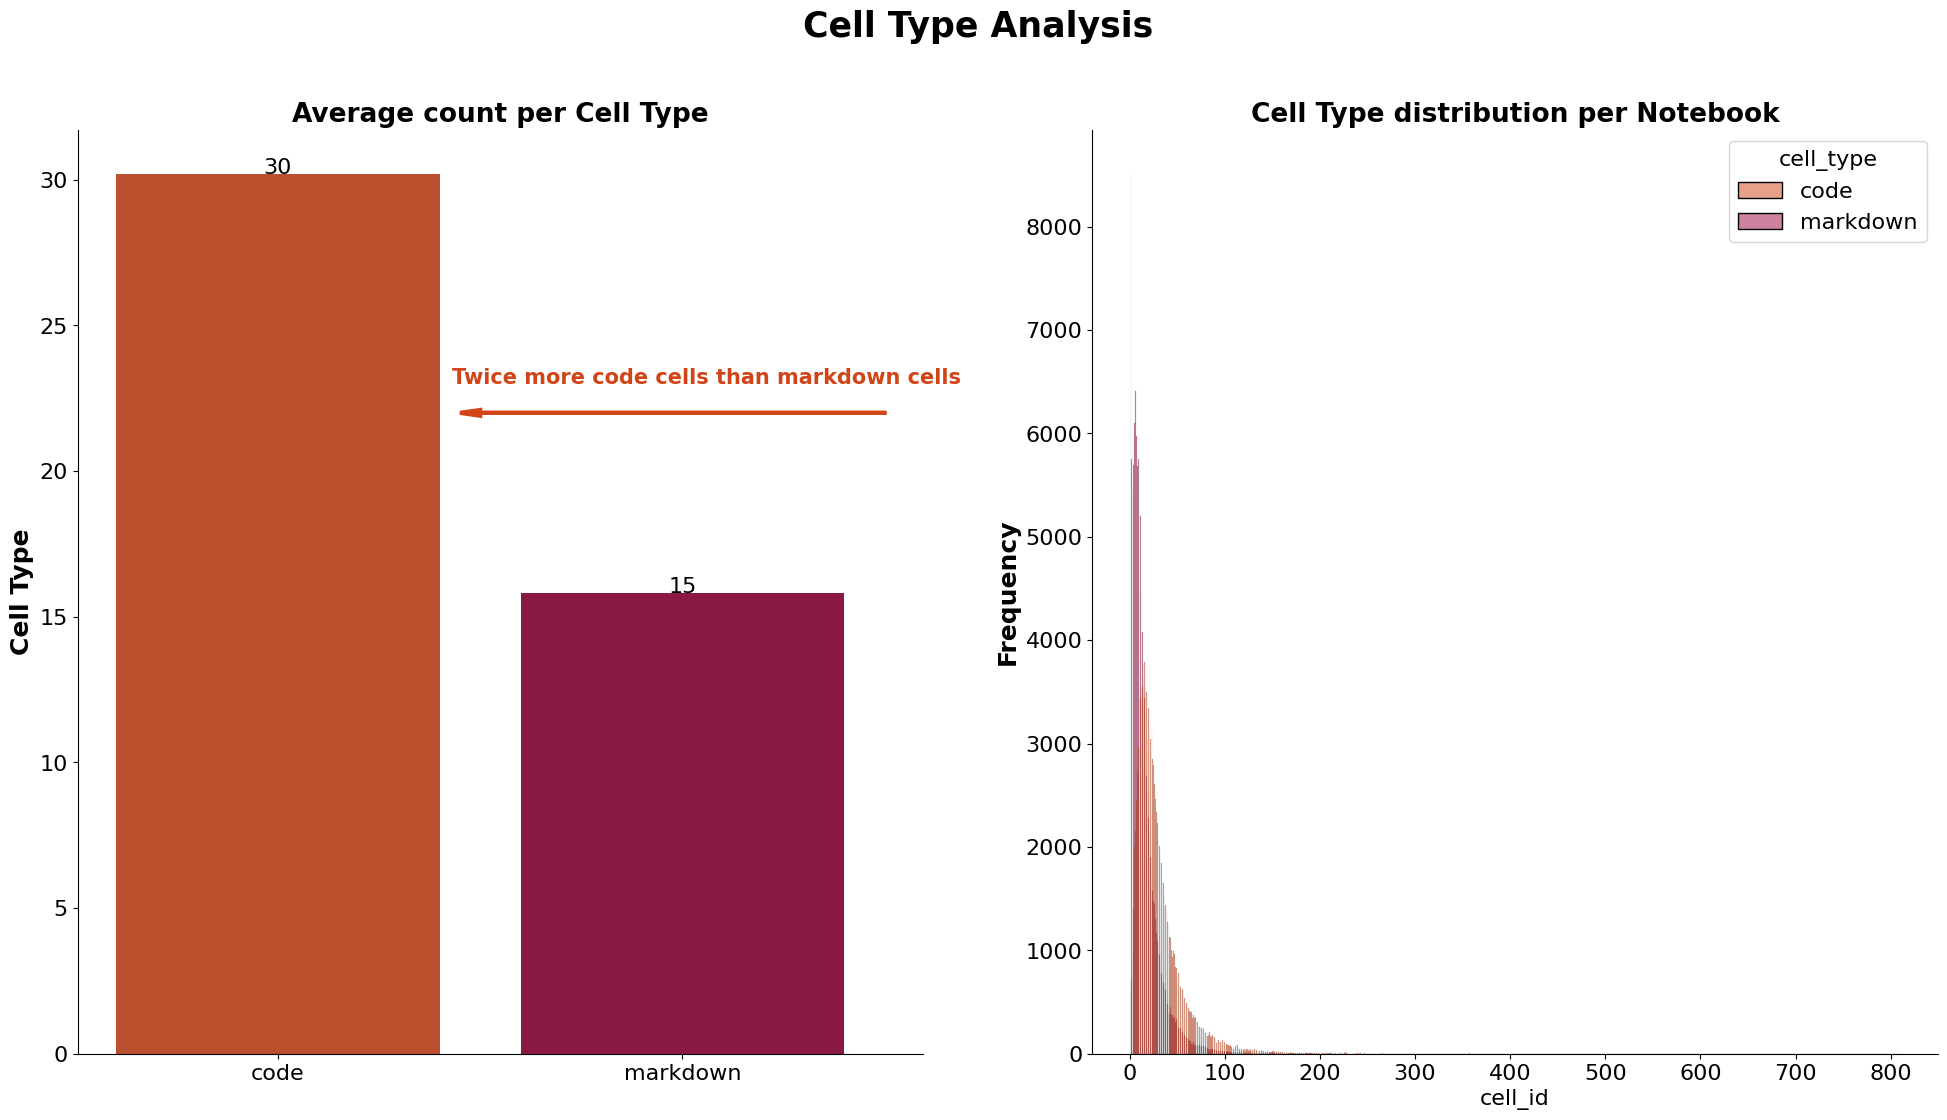

In [53]:
# Data
cell_analysis = train.groupby(["id", "cell_type"])["cell_id"].count().reset_index()
cell_avg = cell_analysis.groupby("cell_type")["cell_id"].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle('Cell Type Analysis', 
             weight="bold", size=25)

# Barplot
sns.barplot(data=cell_avg, x="cell_type", y="cell_id", ax=ax1,
            palette=[my_colors[4], my_darks[-2]])
show_values_on_bars(axs=ax1, h_v="v", space=0.4)
ax1.set_title("Average count per Cell Type", weight="bold", size=19)
ax1.set_ylabel("Cell Type", size = 18, weight="bold")
ax1.set_xlabel("")
ax1.arrow(x=1.5, y=22, dx=-1, dy=0, color=my_colors[4], lw=3, 
          head_width=0.2, head_length=0.05, linestyle = '-')
ax1.text(x=0.43, y=23, s="Twice more code cells than markdown cells",
         color=my_colors[4], size=15, weight="bold")

# Hist
sns.histplot(data=cell_analysis, x="cell_id", hue="cell_type", ax=ax2,
             palette=[my_colors[4], my_darks[-2]])
ax2.set_title("Cell Type distribution per Notebook", weight="bold", size=19)
ax2.set_ylabel("Frequency", size = 18, weight="bold")

sns.despine(right=True, top=True);

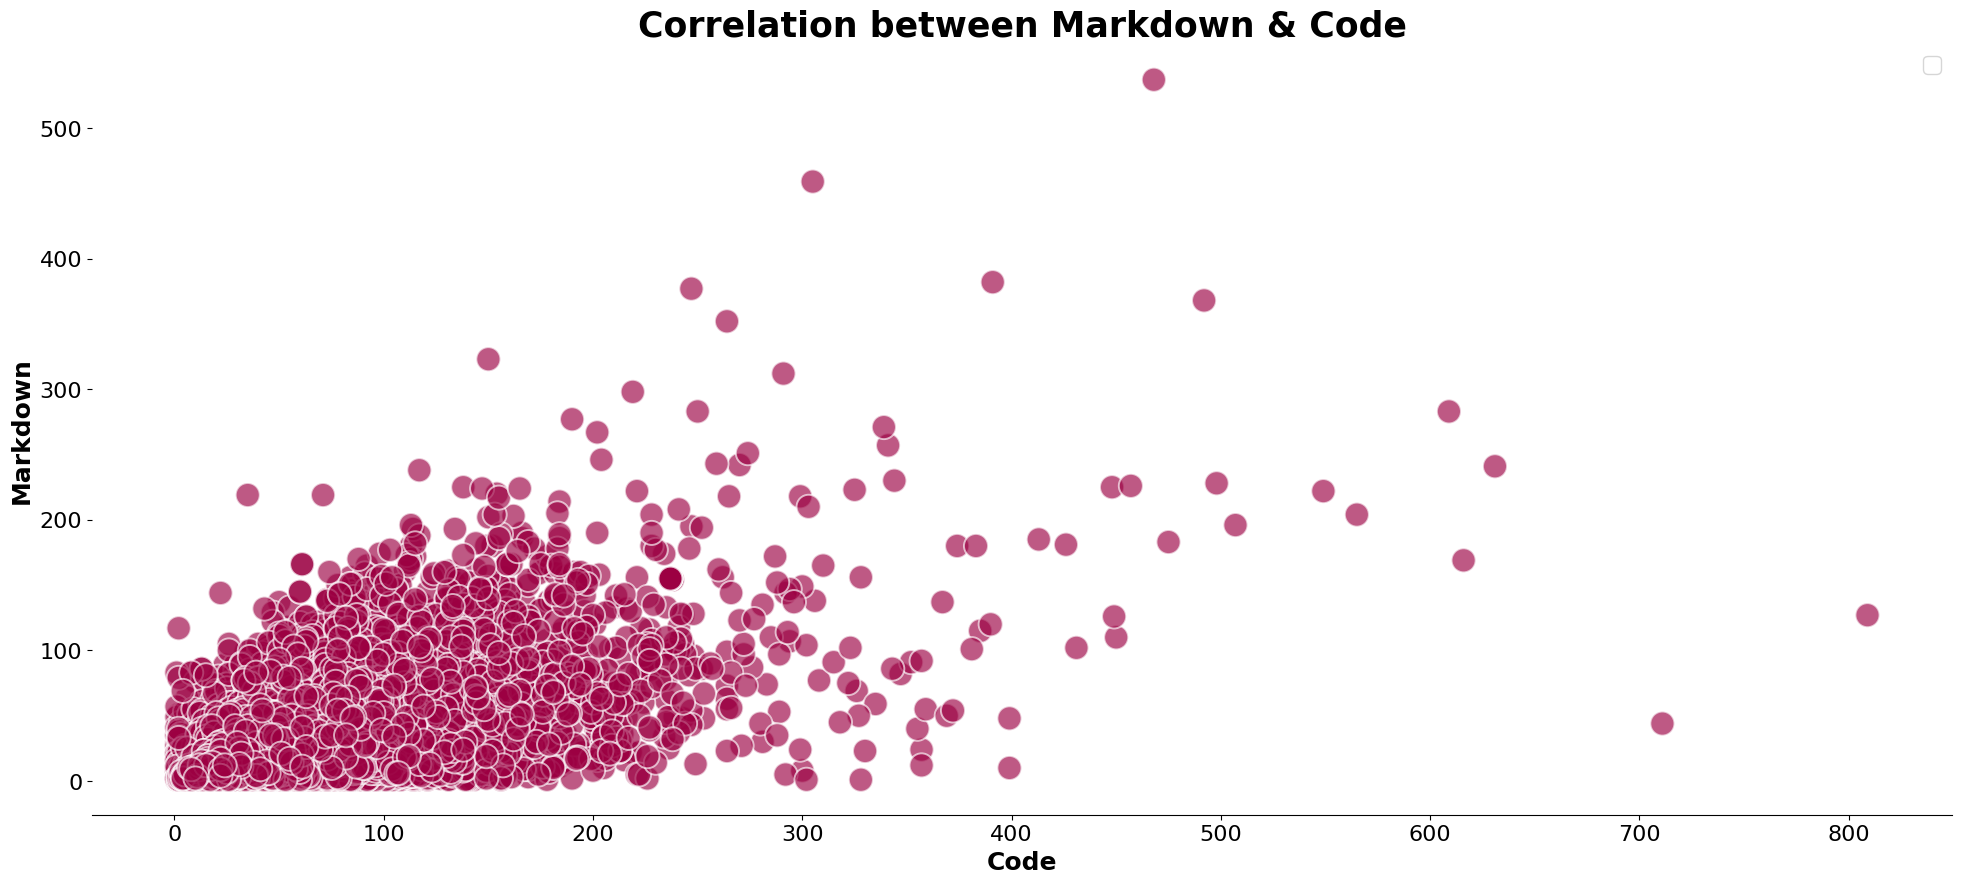

In [54]:
# Data
scatter_data = pd.pivot(data=cell_analysis, index="id", columns="cell_type", values="cell_id")
scatter_data["size"] = 30

plt.figure(figsize=(24, 10))
sns.scatterplot(data=scatter_data, x="code", y="markdown", size="size",
                hue="size", alpha=0.65, palette=CMAP2, sizes=(300, 6000))

plt.title("Correlation between Markdown & Code", weight="bold", size=25)
plt.xlabel("Code", size = 18, weight="bold")
plt.ylabel("Markdown", size = 18, weight="bold")

plt.legend('')

sns.despine(right=True, top=True, left=True);

In [55]:
del cell_analysis, cell_avg, scatter_data
gc.collect()

16973

In [56]:
# ~~~ Choose a % of the data ~~~
PERC_DATA = 0.3
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [57]:
random.seed(24)

# Get all unique ids
unique_ids = train["id"].unique().tolist()
print(clr.S+"Total unique ids:"+clr.E, len(unique_ids))

# Sample down
unique_ids = random.sample(unique_ids, k=int(len(unique_ids)*PERC_DATA))
print(clr.S+"Sampled unique ids:"+clr.E, len(unique_ids))

train = train[train["id"].isin(unique_ids)].reset_index(drop=True)
print(clr.S+"Sampled train Shape:"+clr.E, train.shape)

Total unique ids: 125713
Sampled unique ids: 37713
Sampled train Shape: (1739243, 8)


In [58]:
del unique_ids
gc.collect()

3770

In [59]:
# Size of validation set
NVALID = 0.1

# Create selection object
splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)


# Set column "id" as index
train = train.set_index("id")

# Split, keeping notebooks with a common origin (ancestor_id) together
ids = train.index.unique('id')
ancestor_data = ancestors.set_index('id').loc[ids, 'ancestor_id']
ids_train, ids_valid = next(splitter.split(ids, groups=ancestor_data))
ids_train, ids_valid = ids[ids_train], ids[ids_valid]

# Create train and validation sets
df_train = train.loc[ids_train, :]
df_valid = train.loc[ids_valid, :]

print(clr.S+"Original Shape:"+clr.E, train.shape)
print(clr.S+"Train Shape:"+clr.E, df_train.shape)
print(clr.S+"Valid Shape:"+clr.E, df_valid.shape)

Original Shape: (1739243, 7)
Train Shape: (1569416, 7)
Valid Shape: (169827, 7)


In [65]:
del train, ids, ancestor_data, ids_train, ids_valid
gc.collect()

857

In [84]:
# Remove tokens that have a frequency lower than 15%
tfidf = TfidfVectorizer(min_df=0.05)

# Create the features from the text
# within each cell
X_train = tfidf.fit_transform(df_train['source'].astype(str))

# Create the target variable
# which is the rank (order) of the cells
y_train = df_train["rank"].to_numpy()

# Number of cells in each notebook
groups = df_train.groupby("id")["rank"].max().values

In [85]:
# The same process for data validation
X_valid = tfidf.transform(df_valid['source'].astype(str))
y_valid = df_valid["rank"].to_numpy()

In [88]:
X_train = sparse.hstack((X_train, 
                         np.where(df_train['cell_type']=='code', 
                                  df_train['rank'], 0).reshape(-1, 1)))

X_valid = sparse.hstack((X_valid, 
                         np.where(df_valid['cell_type']=='code', 
                                  df_valid['rank'], 0).reshape(-1, 1)))

In [89]:
groups

array([ 13, 229,  14, ..., 484,  31,  26], dtype=int64)

In [100]:
def train_XGBRanker(XX_train, yy_train, XX_valid, grouping, valid_df):
    
    config_defaults = {"booster":'gbtree',
                   "objective":'rank:pairwise',
                   "random_state":24, 
                   "learning_rate":0.1,
                   "n_estimators":110}
    
    # Initiate the model
    model = XGBRanker(booster='gbtree',
                      objective='rank:pairwise',
                      random_state=24, 
                      learning_rate=0.1,
                      n_estimators=110)

    # Train the model
    model.fit(XX_train, yy_train, group=grouping, verbose=True)

    # Create df containing the cell_id and the prediction
    predict = pd.DataFrame({"cell_id" : valid_df["cell_id"],
                            "pred" : model.predict(XX_valid)}, index = valid_df.index)

    # Sort (using the predicted rank) and then group
    predicted = predict.sort_values(by = ['id', 'pred'], ascending = [False, True])\
                        .groupby('id')['cell_id'].apply(list)

    # Create the same but for actual data
    actual = valid_df.sort_values(by = ['id', 'rank'], ascending = [False, True])\
                            .groupby('id')['cell_id'].apply(list)

    # Kendall Metric
    metric = kendall_tau(actual, predicted)
    print(clr.S+"Kendall Tau"+clr.E, metric)
    return predict, predicted, actual, model
#     wandb.log({"kendall_tau": np.float(metric)})

In [101]:
predict_df, predicted_series, actual_df, model = train_XGBRanker(X_train, y_train, X_valid, groups, df_valid)

Kendall Tau 0.5794857630445827


In [106]:
actual_df

id
0028d10c40d18c    [a34599ec, fec314a3, 7faecf04, f929ee6f, 796d7...
0029a37d79568a    [5ae20870, 57a7c6c4, e8628a75, 8b748a0b, ac947...
0062adfb3f3523    [01748320, 8cbd208f, ccf4b70d, d8e08169, 70b1d...
0069a43a7295a9    [89b3f588, f0caf492, a9e5567c, f4b93fa5, b269f...
0071313d329867    [ff04782b, 2c6a0c53, ce86104e, ff2de52a, d06e0...
                                        ...                        
fff2369e5f3fae    [619c5d06, 83763dae, a47fef1c, 0b264008, 0ff20...
fff470fc4b198e    [2e7d3b2a, bac026cb, d0c01fac, 3a97eaa1, e010b...
fff6b47522f8b4    [1504d327, 1f149549, 5a552e48, 5bd6030b, 95ba0...
fffa0665b5ec46    [45bad197, 8aef874b, 4cf0ac0f, cfe10f06, 7525d...
fffbd2e276f908    [7a65e69a, 8d07b78c, dbce8452, 85d932df, 8c258...
Name: cell_id, Length: 3779, dtype: object

In [107]:
predicted_series

id
0028d10c40d18c    [0fa2a550, 4ec335ba, 2bf98b43, d3b47f0f, ca8f4...
0029a37d79568a    [57a7c6c4, e8628a75, 8b748a0b, e95fb1a0, b6be7...
0062adfb3f3523    [01748320, 8cbd208f, ccf4b70d, d8e08169, 70b1d...
0069a43a7295a9    [89b3f588, f0caf492, a9e5567c, f4b93fa5, 3db08...
0071313d329867    [47a732d6, 65b84fdd, f9ba0e8c, 4f130d8f, c571c...
                                        ...                        
fff2369e5f3fae    [a47fef1c, 0ff20d3f, e2c6f9aa, 2f513c34, 34193...
fff470fc4b198e    [bac026cb, d0c01fac, 3a97eaa1, e010bcda, 59992...
fff6b47522f8b4    [1504d327, 5a552e48, 5bd6030b, 95ba0d80, 45681...
fffa0665b5ec46    [45bad197, 8aef874b, 7525dfab, 4cf0ac0f, 8e961...
fffbd2e276f908    [7a65e69a, dbce8452, 85d932df, 8c2583ad, 3dc58...
Name: cell_id, Length: 3779, dtype: object

In [115]:
prdf = predicted_series.explode().to_frame('cell_order_predicted').reset_index()
prdf['rank_prd'] = 1
prdf['rank_prd'] = prdf.groupby(['id'])['rank_prd'].cumsum()

In [121]:
valid_result = df_valid.reset_index().merge(prdf, left_on = ['id', 'cell_id'], right_on = ['id', 'cell_order_predicted'])[['id', 'cell_id','cell_type', 'rank', 'rank_prd']]

In [124]:
valid_result[(valid_result.cell_type == 'markdown') & (valid_result['rank'] == valid_result['rank_prd'])].shape

(1562, 5)

In [125]:
valid_result[(valid_result.cell_type == 'code') & (valid_result['rank'] == valid_result['rank_prd'])].shape

(10535, 5)